In [1]:
%matplotlib widget
import numpy as np
import json, os, glob
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *

import warnings
warnings.filterwarnings('ignore')

# Reduce data 

In [8]:
pgroup = 'p22197'

#runlist = [68, 71, 70 ,73]
runlist = [98]

##############################################
from textwrap import wrap
from sfdata import SFScanInfo
jsonlist = []
for run in runlist:
    jsonfile = ''
    jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))[0]
    #jsonfile = glob.glob('/sf/alvra/data/{}/work/testdata/*{:04d}*/meta/scan.json'.format(pgroup, run))[0]
    jsonlist.append(jsonfile)
print ("will reduce {} run(s): {}".format(len(jsonlist), runlist))
titlestring = pgroup + ' --- ' +str(runlist)
jsonlist

will reduce 1 run(s): [98]


['/sf/alvra/data/p22197/raw/run0098-test_xanes_2D_7to1/meta/scan.json']

In [10]:
channel_delay_motor = channel_delay_beckhoff
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110

dir2save = 'test_noPair'

TT = TT_PSEN126
saveflag = True

###########################################################3
reducedir='/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, dir2save)

#pump_1, unpump_1, pump_2, unpump_2, pump_1_raw, unpump_1_raw, pump_2_raw, unpump_2_raw, Izero_pump, Izero_unpump, Delays_stage, arrTimes, Delays_corr, energy, energypad, readbacks, corr1, corr2 = \
#Reduce_scan_PP(reducedir, saveflag, jsonlist, TT, channel_delay_motor, detector_XAS_1, detector_XAS_2, detector_Izero)

pump_1, pump_2, pump_1_raw, pump_2_raw, Izero_pump, Delays_stage, arrTimes, Delays_corr, energy, energypad, readbacks, corr1, corr2, lights, darks = \
Reduce_scan_PP_noPair(reducedir, saveflag, jsonlist, TT, channel_delay_motor, detector_XAS_1, detector_XAS_2, detector_Izero)

/sf/alvra/data/p22197/raw/run0098-test_xanes_2D_7to1/meta/scan.json
Step 13 of 13: Processing acq0013

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet          1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-CVME-EVR0:DUMMY_PV3_NBS   992 / 1003 -> 1% loss ▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH1_VAL_GET     1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH2_VAL_GET     1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY        1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-L-BECKBS:PR1_CH4_VAL_GET 1001 / 1003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 990 / 1003 -> 1% loss
complete channels: 0 / 6 -> 100% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 12.5 Hz (delayed or dark)
Pump scheme is 7:1
Loaded 867 pump and 123 unpump shots
correlation Diode1 (ALL shots) = -0.020600481287553804
correlation Diode2 (ALL shots) = 0.009356871890853286
-----

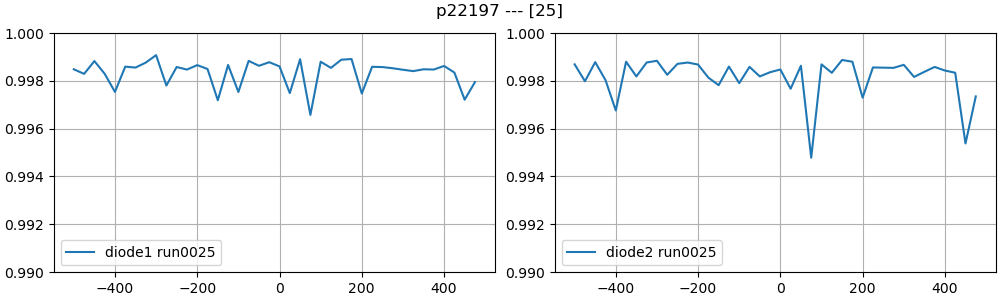

In [4]:
Plot_correlations_scan(pgroup, reducedir, runlist, timescan=True, lowlim = 0.99)

Time delay axis rebinned with delay stage data
Time delay axis rebinned with delay stage data


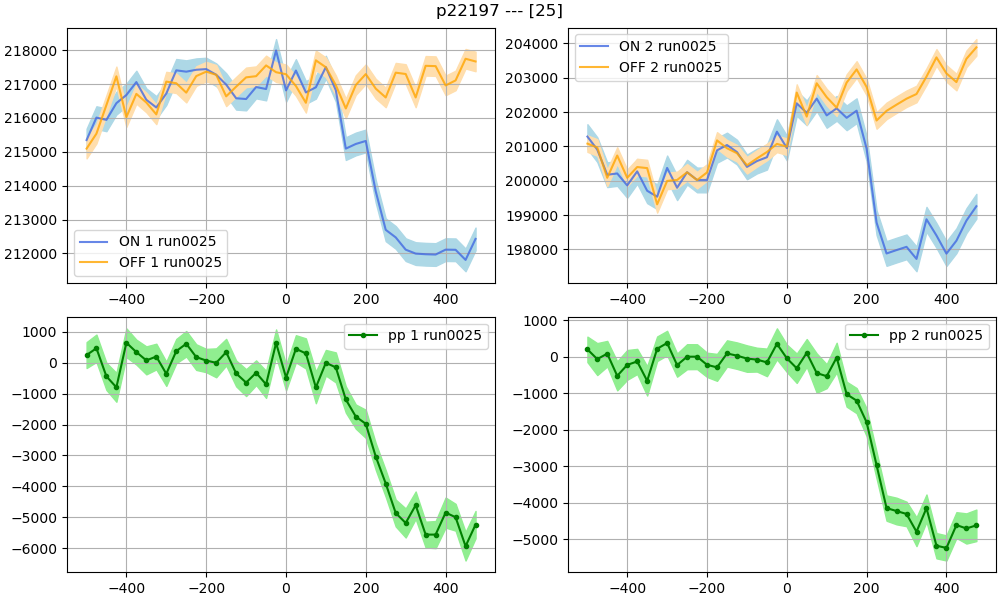

In [5]:
Plot_scan_2diodes_noPair(pgroup, reducedir, runlist, timescan=True, threshold=0.05)

In [2]:
def load_data_compact_pump_probe(channels_pump_unpump, channels_FEL, data, offsets=None):

    offsets = offsets or {}
    for chname, value in offsets.items():
        data[chname].offset = value
   
    channels_pump_unpump = check_channels(data, channels_pump_unpump, "pump unpump")
    channels_FEL = check_channels(data, channels_FEL, "FEL")

    subset_FEL = data[channels_FEL]
    subset_FEL.print_stats(show_complete=True)
    
    Event_code = subset_FEL[channel_Events].data
    FEL = Event_code[:,13] #Event 13: changed from 12 on June 22
    
    Deltap_FEL = (1 / FEL.mean()).round().astype(int) #Get the FEL rep rate from the Event code
    FEL_reprate = 100 / Deltap_FEL
    print ('FEL rep rate is {} Hz'.format(FEL_reprate))
    
    subset_FEL.drop_missing()

    Event_code = subset_FEL[channel_Events].data
    
    FEL_raw  = Event_code[:,13] #Event 13: changed from 12 on June 22
    Ppicker  = Event_code[:,200]
    Laser    = Event_code[:,18]
    Darkshot = Event_code[:,21]

    #FEL = np.logical_and(FEL_raw, np.logical_not(Ppicker))
    FEL = FEL_raw

    if Darkshot.mean()==0:
        laser_reprate = (1 / Laser.mean()).round().astype(int)
        index_light = np.logical_and.reduce((FEL, Laser))
        index_dark  = np.logical_and.reduce((FEL, np.logical_not(Laser)))
    else:
        laser_reprate = (Laser.mean() / Darkshot.mean()).round().astype(int) 
        index_light = np.logical_and.reduce((FEL, Laser, np.logical_not(Darkshot)))
        index_dark = np.logical_and.reduce((FEL, Laser, Darkshot))
    print (np.shape(index_light))
    print ('Laser rep rate is {} Hz (delayed or dark)'.format(100 / laser_reprate))
    print ('Pump scheme is {}:1'.format(laser_reprate - 1))

    result_pp = {}
    meta = defaultdict(list)
    for ch in channels_pump_unpump:
        ch_pump   = subset_FEL[ch].data[index_light]
        pids_pump   = subset_FEL[ch].pids[index_light]

        ch_unpump = subset_FEL[ch].data[index_dark]
        pids_unpump = subset_FEL[ch].pids[index_dark]

        correct_pids_pump   = pids_unpump + Deltap_FEL
        final_pids, indPump, indUnPump = np.intersect1d(pids_pump, correct_pids_pump, return_indices=True)
        
        pids_pump=pids_pump[indPump]
        pids_unpump=pids_unpump[indUnPump]

        if (((100 / Deltap_FEL) / (laser_reprate - 1)) == FEL_reprate):
            ch_pump   = ch_pump[indPump]
            ch_unpump = ch_unpump[indUnPump] 

        ppdata = namedtuple("PPData", ["pump", "unpump"])
        result_pp[ch] = ppdata(pump=ch_pump, unpump=ch_unpump)

        # old sfdata does not have the meta attribute, so we cannot check for it
        try:
            chmeta = subset_FEL[ch]._group["meta"]
        except:
            chmeta = None

        if chmeta:
            for k,v in chmeta.items():
                meta[ch + "-" + k] = v[()]
        
        #if subset_FEL[ch].meta:
        #    chmeta = subset_FEL[ch].meta
        #    for k,v in chmeta.items():
        #        meta[ch + "-" + k] = v[()]

    result_pp["meta"] = meta

    result_FEL = {}
    for ch in channels_FEL:
        result_FEL[ch] = subset_FEL[ch].data 

    print ("Loaded {} pump and {} unpump shots".format(len(ch_pump), len(ch_unpump)))

    return result_pp, result_FEL, index_light, index_dark

In [3]:
def Reduce_scan_PP(reducedir, saveflag, jsonlist, TT, motor, diode1, diode2, det_Izero, shots2average=None):
    
    if TT == TT_PSEN124:
        TT = [channel_PSEN124_arrTimes, channel_PSEN124_arrTimesAmp]
        channel_arrTimes = channel_PSEN124_arrTimes
        channel_arrTimesAmp = channel_PSEN124_arrTimesAmp
    elif TT == TT_PSEN126:
        TT = [channel_PSEN126_arrTimes, channel_PSEN126_arrTimesAmp]
        channel_arrTimes = channel_PSEN126_arrTimes
        channel_arrTimesAmp = channel_PSEN126_arrTimesAmp

    channels_pp = [channel_Events, diode1, diode2, det_Izero, motor, channel_monoEnergy] + TT
    channels_all = channels_pp
    
    from sfdata import SFScanInfo
    

    pump_1, pump_2, I_zero, Delays_stage, arrTimes, Delays_corr, energy, energypad, readbacks, corr1, corr2, lights, darks = ([] for i in range(13))
    
    for jsonfile in jsonlist:
        runname = jsonfile.split('/')[-3]
        scan = SFScanInfo(jsonfile)
        rbk = np.ravel(scan.readbacks)
        unique = np.roll(np.diff(rbk, prepend=1)>0.001, -1)
        #unique = np.diff(rbk, prepend=1)>0.001
        rbk = rbk[unique]

        p1, p2, Ip, ds, aT, dc, en, en2, c1, c2, li, da = ([] for i in range(12))

        for i, step in enumerate(scan):
            check_files_and_data(step)
            check = get_filesize_diff(step)  
            go = unique[i]

            if check & go:
                clear_output(wait=True)
                filename = scan.files[i][0].split('/')[-1].split('.')[0]
                print (jsonfile)
                print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
                resultsPP, results, li1, da1 = load_data_compact_pump_probe(channels_pp, channels_all, step)
                print (np.shape(li1))
                li.extend(li1)
                da.extend(da1)
                
                p1.extend(results[diode1])
                p2.extend(results[diode2])
                
                Ip.extend(results[det_Izero])
                
                ds.extend(results[motor])
                aT.extend(results[channel_arrTimes])
                dc.extend(results[motor] + results[channel_arrTimes])

                enshot = results[channel_monoEnergy]
                en.extend(enshot)
                #en2 = np.pad(en2, (0,len(enshot)), constant_values=(np.random.normal(rbk[i],0.01,1)))
                en2 = np.pad(en2, (0,len(enshot)), constant_values=(np.nanmean(enshot)))

                pearsonr1 = pearsonr(results[diode1],results[det_Izero])[0]
                pearsonr2 = pearsonr(results[diode2],results[det_Izero])[0]

                c1.append(pearsonr1)
                c2.append(pearsonr2)

                print ("correlation Diode1 (dark shots) = {}".format(pearsonr1))
                print ("correlation Diode2 (dark shots) = {}".format(pearsonr2))

        # u1 = u1_raw/np.nanmean(np.array(u1_raw)[:shots2average])
        # p1 = p1_raw/np.nanmean(np.array(u1_raw)[:shots2average])
        # u2 = u2_raw/np.nanmean(np.array(u2_raw)[:shots2average])        
        # p2 = p2_raw/np.nanmean(np.array(u2_raw)[:shots2average])        

        if saveflag:
            os.makedirs(reducedir+runname, exist_ok=True)
            save_reduced_data_scanPP(reducedir, runname, scan, p1, u1, p2, u2, p1_raw, u1_raw, p2_raw, u2_raw, Ip, Iu, ds, aT, dc, en, en2, rbk, c1, c2)
                
        pump_1.extend(p1)
        pump_2.extend(p2)
        lights.extend(li)
        darks.extend(da)
        
        I_zero.extend(Ip)
        
        Delays_stage.extend(ds)
        arrTimes.extend(aT)
        Delays_corr.extend(dc)
        energy.extend(en)
        energypad.extend(en2)
        #readbacks.append(rbk)
        corr1.append(c1)
        corr2.append(c2)

    print ('----------------------------')
    print ('Loaded {} total on/off pairs'.format(len(Delays_corr)))

    return (pump_1, pump_2, I_zero, Delays_stage, arrTimes, Delays_corr, energy, energypad, rbk, corr1, corr2, lights, darks)



In [4]:
pgroup = 'p22197'

#runlist = [68, 71, 70 ,73]
runlist = [89]

##############################################
from textwrap import wrap
from sfdata import SFScanInfo
jsonlist = []
for run in runlist:
    jsonfile = ''
    jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))[0]
    #jsonfile = glob.glob('/sf/alvra/data/{}/work/testdata/*{:04d}*/meta/scan.json'.format(pgroup, run))[0]
    jsonlist.append(jsonfile)
print ("will reduce {} run(s): {}".format(len(jsonlist), runlist))
titlestring = pgroup + ' --- ' +str(runlist)
jsonlist

will reduce 1 run(s): [89]


['/sf/alvra/data/p22197/raw/run0089-Fe2_CytC_XAS_pre_edge_2D_scan_001/meta/scan.json']

In [5]:
channel_delay_motor = channel_delay_beckhoff
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110

dir2save = 'XANES'

TT = TT_PSEN126
saveflag = False

###########################################################3
reducedir='/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, dir2save)

pump_1, pump_2, Izero, Delays_stage, arrTimes, Delays_corr, energy, energypad, readbacks, corr1, corr2, lights, darks = \
Reduce_scan_PP(reducedir, saveflag, jsonlist, TT, channel_delay_motor, detector_XAS_1, detector_XAS_2, detector_Izero)

/sf/alvra/data/p22197/raw/run0089-Fe2_CytC_XAS_pre_edge_2D_scan_001/meta/scan.json
Step 21 of 21: Processing acq0021

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet          15001 / 15003 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-CVME-EVR0:DUMMY_PV3_NBS  14874 / 15003 ->  1% loss ▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH1_VAL_GET     15001 / 15003 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH2_VAL_GET     15001 / 15003 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY        14444 / 15003 ->  4% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-L-BECKBS:PR1_CH4_VAL_GET 13847 / 15003 ->  8% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 13219 / 15003 -> 12% loss
complete channels: 0 / 6 -> 100% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
(13219,)
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 5862 pump and 5862 unpump shots
(13219,)
correlation Diode1 (dark shots) = 0.9981239488541439
correl

In [7]:
minvalue = -250
maxvalue = +750
binsize = 15
quantile = 0.7

binList = np.arange(minvalue, maxvalue, binsize)
bin_centres = (binList[:-1] + binList[1:])/2
delay_rebin = np.arange(minvalue + binsize/2, maxvalue - binsize/2, binsize)

In [8]:
ordered = np.argsort(np.asarray(energypad))
peaks, what = find_peaks(np.diff(np.asarray(energypad)[ordered]))

pump_1       = np.asarray(pump_1)[ordered]
Izero        = np.asarray(Izero)[ordered]
Delays_stage = np.asarray(Delays_stage)[ordered]
lights       = np.asarray(lights)[ordered]
darks        = np.asarray(darks)[ordered]

starts = np.append(0, peaks)
ends = np.append(peaks, None)

In [9]:
pump_in_ebin, Izero_in_ebin, Delays_in_ebin, lights_in_ebin, darks_in_ebin = ([] for i in range(5))
pp_rebin = np.zeros((len(starts), len(bin_centres)))

print (len(peaks), len(readbacks), len(bin_centres))
for i, (s, e) in enumerate(zip(starts, ends)):
    pump_in_ebin = pump_1[s:e]
    Izero_in_ebin = Izero[s:e]
    Delays_in_ebin = Delays_stage[s:e]
    lights_in_ebin = lights[s:e]
    darks_in_ebin = darks[s:e]

    thresh   = (Izero_in_ebin > 0)
    filterI = Izero_in_ebin > (np.nanmedian(Izero_in_ebin) - np.std(Izero_in_ebin))

    pump_in_ebin   = pump_in_ebin[filterI & thresh]
    Izero_in_ebin  = Izero_in_ebin[filterI & thresh]
    Delays_in_ebin = Delays_in_ebin[filterI & thresh]
    lights_in_ebin = lights_in_ebin[filterI & thresh]
    darks_in_ebin  = darks_in_ebin[filterI & thresh]

    for j in range(len(bin_centres)):
        cond1 = np.asarray(Delays_in_ebin) >= binList[j]
        cond2 = np.asarray(Delays_in_ebin) < binList[j+1]

        idx = np.where(cond1*cond2)[0]
        delay_rebin[j]  = np.average(np.asarray(Delays_in_ebin)[idx])
        
        pump_in_tbin    = np.asarray(pump_in_ebin)[idx]
        Izero_in_tbin = np.asarray(Izero_in_ebin)[idx]
        lights_in_tbin  = np.asarray(lights_in_ebin)[idx]
        darks_in_tbin   = np.asarray(darks_in_ebin)[idx]

        Diode_norm = pump_in_tbin / Izero_in_tbin
        qnt_low  = np.nanquantile(Diode_norm, 0.5 - quantile/2)
        qnt_high = np.nanquantile(Diode_norm, 0.5 + quantile/2)

        condition_low = Diode_norm > qnt_low
        condition_high = Diode_norm < qnt_high

        correlation_filter = condition_low & condition_high

        Diode_filter  = pump_in_tbin[correlation_filter]
        Izero_filter  = Izero_in_tbin[correlation_filter]
        darks_filter  = darks_in_tbin[correlation_filter]
        lights_filter = lights_in_tbin[correlation_filter]
        
        p  = Diode_filter[lights_filter]
        u  = Diode_filter[darks_filter]
        Ip = Izero_filter[lights_filter]
        Iu = Izero_filter[darks_filter]
        #print (len(p), len(u))
        p = p/Ip
        u = u/Iu
        pp_rebin[i, j]  = np.log10(np.nanmean(p)/np.nanmean(u))
        # np.mean(p)-np.mean(u)
        

20 21 66


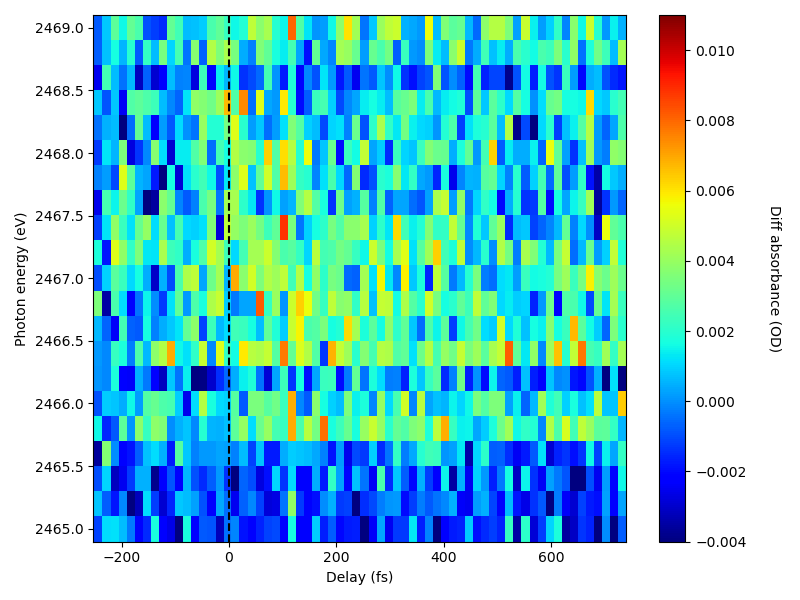

In [10]:
baseline = np.average(pp_rebin[:,0:2], axis=1)
baseline = baseline[:, np.newaxis]

# Delay_fs_TT_2 = Delay_fs_TT[~np.isnan(Delay_fs_TT)]
# pp_TT = pp_TT[:,~np.isnan(Delay_fs_TT)]

plt.figure(figsize=(8, 6))
#plt.rcParams.update({'font.size': 15})
#plt.suptitle(titlestring_stack)
#plt.title(runlist)
plt.pcolormesh(delay_rebin, readbacks, pp_rebin-baseline, cmap='jet', vmin=-0.004, vmax = 0.011)
#plt.pcolormesh(pp_TT-baseline, cmap='bwr', vmin=-0.1, vmax = 0.1)
#plt.ylabel('{} ({})'.format(scan.parameters['name'][0],scan.parameters['units'][0]))
plt.ylabel('Photon energy (eV)')

cbar = plt.colorbar(fraction=0.15)
cbar.set_label('Diff absorbance (OD)', rotation=270, labelpad=25)

#plt.colorbar()
plt.xlabel('Delay (fs)')
plt.axvline(x = 0, color = 'k', linestyle = '--')
#plt.grid()
plt.tight_layout()
plt.show()

<a id='old'></a>
## Old

In [118]:
pgroup='p21960'
runnumber = 45

print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/work/testdata/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str(pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0045


'/sf/alvra/data/p21960/work/testdata/run0045-FePhen_Timescan_7119p5eV_001/meta/scan.json'

In [119]:
Two_diodes = True

reducedir='/sf/alvra/data/{}/work/Reduced_data/old_way/'.format(pgroup)
saveflag=True

quantile_corr = 0.7

channel_delay_motor = channel_delay_topas
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero122

#######################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

LoadXANES(Two_diodes, scan, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr, saveflag, reducedir, run_name)
data, _ = load_reduced_data(pgroup, reducedir, [runnumber])
globals().update(data)

Processing: run0045-FePhen_Timescan_7119p5eV_001
Step 111 of 111: Processing acq0111

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet      1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH1_VAL_GET 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH2_VAL_GET 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY    1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 490 pump and 490 unpump shots
240 shots out of 490 survived
247 shots out of 490 survived
Step 111 of 111: Processed acq0111
correlation Diode1 (all shots) = -0.06602945503846193
correlation Diode2 (all shots) = -0.046775091336307334
------------------------------
Processed 111 out of 111 files


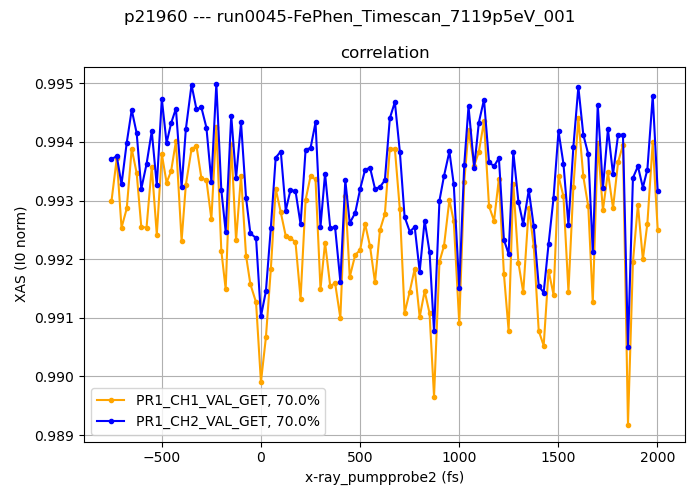

In [10]:
if not Two_diodes:
    detector_XAS_2 = detector_XAS_1
Plot_correlation(titlestring, scan, data, quantile_corr, detector_XAS_1, detector_XAS_2, timescan=False)

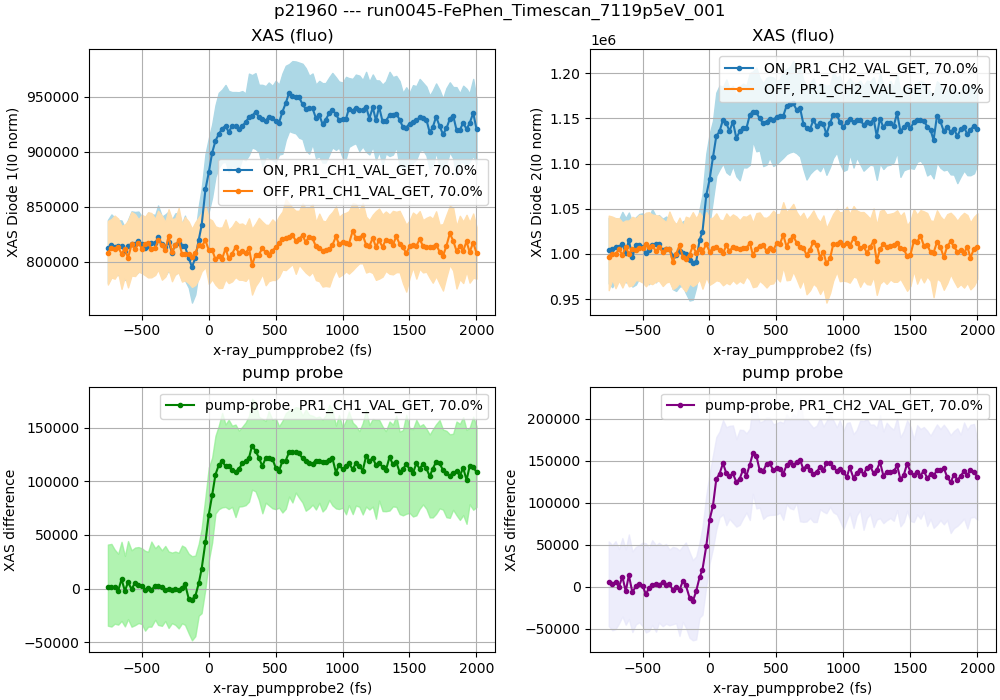

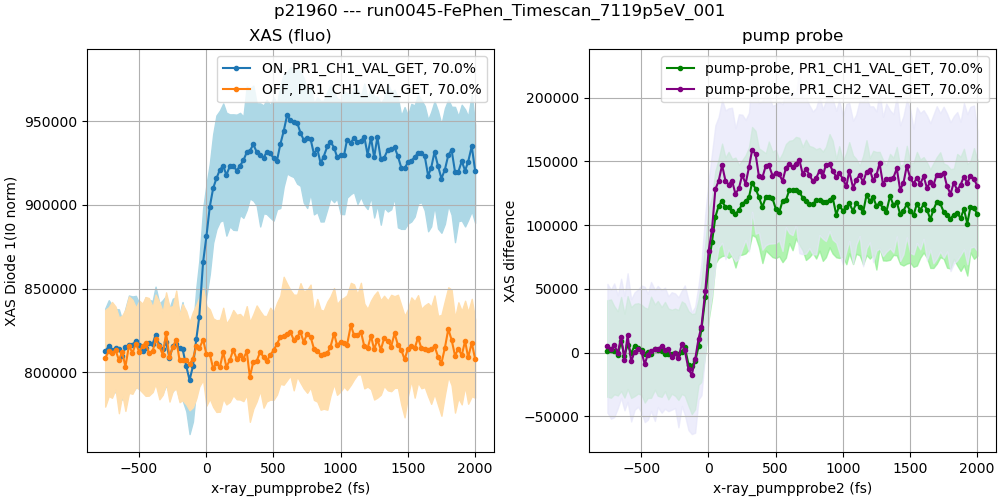

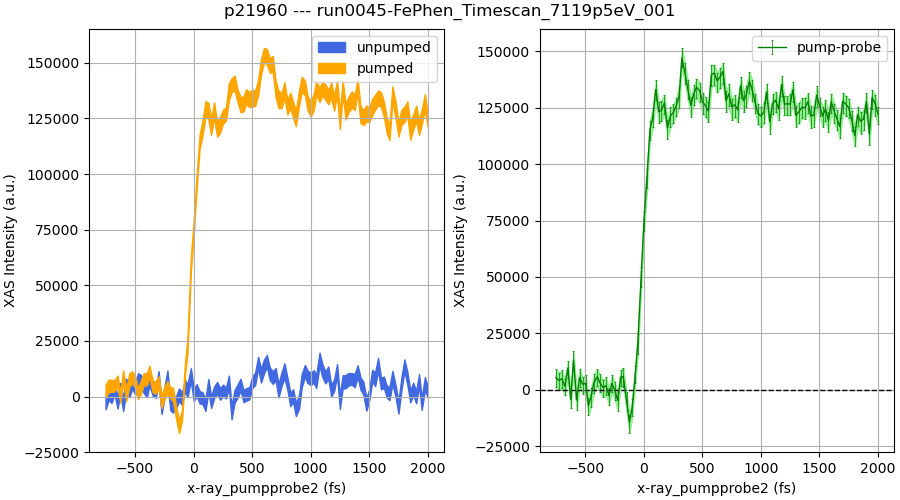

In [11]:
if Two_diodes:
    XAS1_pump_probe, XAS2_pump_probe, Energy_eV = Plot_2diodes_4figs(titlestring, scan, data, 
                                                              quantile_corr, detector_XAS_1, detector_XAS_2, timescan=False)
    XAS1_pump_probe, XAS2_pump_probe, Energy_eV = Plot_2diodes_2figs(titlestring, scan, data, 
                                                              quantile_corr, detector_XAS_1, detector_XAS_2, timescan=False)
    
    Energy_eV, ave_pp1 = Plot_2diodes_Averaged_2figs(titlestring, scan, data, timescan=False)
else:
    XAS1_pump_probe, Energy_eV = Plot_1diode(titlestring, scan, data, 
                                            quantile_corr, detector_XAS_1, timescan=False)